# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
#
# if it prints otherwise, then you need to enable GPU:
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
import PIL
print(PIL.__version__)

11.0.0


In [3]:
# использую kaggle, поэтому закомментирую данные строки

from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
# использую kaggle, поэтому закомментирую данную строку
!unzip /content/gdrive/MyDrive/journey-springfield.zip

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train/simpsons_dataset/moe_szyslak/pic_1025.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1026.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1027.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1028.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1029.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1030.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1031.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1032.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1033.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1034.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1035.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1036.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1037.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pic_1038.jpg  
  inflating: train/simpsons_dataset/moe_szyslak/pi

In [5]:
# !ls train

In [6]:
!nvidia-smi
import torch
torch.cuda.is_available()

Wed Nov 20 17:55:51 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8              10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [7]:
import pickle
import numpy as np
from skimage import io
import sys

from tqdm.notebook import tqdm
from PIL import Image
from pathlib import Path

from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [8]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [51]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

        # данных не очень много, поэтому добавим аугментации
        transform_2 = transforms.Compose([
            transforms.RandomRotation(180),
            transforms.RandomHorizontalFlip(p=0.5)
        ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            x = transform_2(x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [52]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
#определим директории с тренировочными и тестовыми файлами

TRAIN_DIR = Path('./train/')
TEST_DIR = Path('./testset')

# TRAIN_DIR = Path('/kaggle/input/journey-springfield-zip/train')
# TEST_DIR = Path('/kaggle/input/journey-springfield-zip/testset')

In [12]:
train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [27]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files,
                                          test_size=0.2,
                                          stratify=train_val_labels)

In [49]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [65]:
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=2)

val_loader[0]

TypeError: 'DataLoader' object is not subscriptable

In [18]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions):
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

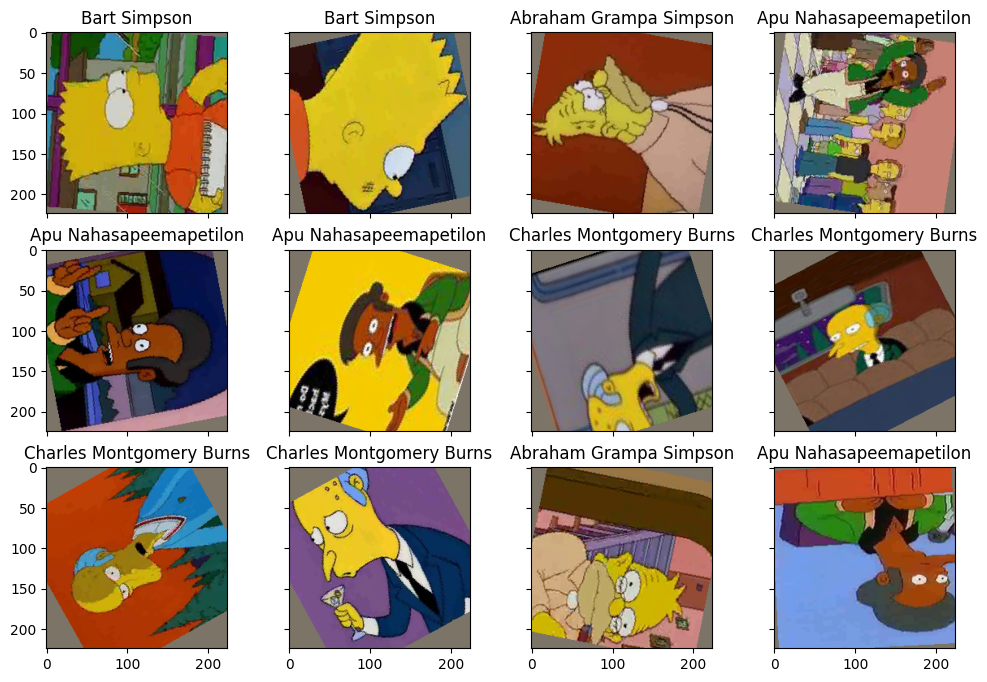

In [53]:
fig, ax = plt.subplots(nrows=3, ncols=4,figsize=(12, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [54]:
# Очень простая сеть
# сразу добавлю в эту сеть BatchNorm2d
class SimpleCnn(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.out = nn.Linear(96 * 5 * 5, n_classes)


    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [55]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [56]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.cpu().numpy() / processed_size
    return val_loss, val_acc

In [57]:
# доработаю функцию. она будет возвращать не вероятности а сразу предсказания
def predicts(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probabilities = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    predictions = probabilities.argmax(-1)
    return predictions

In [58]:
# ради спортивного интереса добавлю расчет f1_score после каждой эпохи
def f1_in_epoch(model, loader):
    f = 0
    n = 0
    for inputs, labels in loader:
        y_predict = predicts(model, inputs.unsqueeze(0))
        f += f1_score(labels, y_predict, average='micro')
        n += 1
        if n == 3:
            return f / n


In [59]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False, num_workers=4)

    history = []
    log_template = "\nEpoch  {ep:02d}   train_loss:  {t_loss:0.4f}   val_loss  {v_loss:0.4f}\
            train_acc  {t_acc:0.4f}   val_acc  {v_acc:0.4f}   val_f1  {v_f1:0.3f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            f_1 = f1_in_epoch(model, val_loader)

            history.append((train_loss, train_acc, val_loss, val_acc, f_1))

            if val_loss < 0.001:
                return history

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc, v_f1=f_1))

    return history

In [60]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

we will classify :42
SimpleCnn(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

Запустим обучение сети.

In [61]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

len(val_dataset)

4187

In [ ]:
simple_cnn_train_history = train(train_dataset, val_dataset, simple_cnn, epochs=10, batch_size=66)

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc, f_1 = zip(*simple_cnn_train_history)

посмотрим на графиках, как менялся loss и accuracy

In [ ]:
def plotting_loss(loss, val_loss):
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()

def plotting_acc(acc, val_acc):
    plt.figure(figsize=(15, 9))
    plt.plot(acc, label="train_acc")
    plt.plot(val_acc, label="val_acc")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.show()

In [ ]:
# посмотрим на графики
plotting_loss(loss, val_loss)
plotting_acc(acc, val_acc)

### Ну и что теперь со всем этим делать?

Хорошо бы понять, как сделать сабмит.
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
# сделаю функцию, т.к. вычислять f1_score нужно будет не один раз

def f1_score_val_dataset(model, val_dataset):

    idxs = (range(len(val_dataset)))    # map(int, np.random.uniform(0,4000, 2000))
    imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

    y_pred = predicts(model, imgs)
    preds_class = [label_encoder.classes_[i] for i in y_pred]

    actual_labels = [val_dataset[id][1] for id in idxs]

    f1 = f1_score(actual_labels, y_pred, average='micro')

    print("F1-score:", f1)

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
#
f1_score_val_dataset(simple_cnn, val_dataset)
# F1-score: 0.7837

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

### Submit на Kaggle

In [ ]:
! ls

label_encoder.pkl


In [ ]:
import pandas as pd

# сделаю функцию, т.к. сохранять нужно будет не один раз
def save_submit(model, file_name):
    test_dataset = SimpsonsDataset(test_files, mode="test")
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=100)
    preds = predicts(model, test_loader)

    preds = label_encoder.inverse_transform(preds)
    test_filenames = [path.name for path in test_dataset.files]
    my_submit = pd.read_csv('/kaggle/input/journey-springfield-zip/sample_submission.csv')
    my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})

    my_submit.to_csv(file_name, index=False)

In [ ]:
# сохраню submit
save_submit(simple_cnn, 'simple_cnn_baseline.csv')

## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать.

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову:


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)


In [ ]:
! pip install torchsummary

In [ ]:
from torchvision import models
from itertools import chain
from torchsummary import summary

In [ ]:
# немного изменю функцию train

def my_train(train_files, val_files, model, criterion, optimizer, epochs, batch_size, scheduler=False):
    train_loader = DataLoader(train_files, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_files, batch_size=batch_size, shuffle=False, num_workers=4)

    history = []
    log_template = "\nEpoch  {ep:02d}   train_loss=  {t_loss:0.4f}   val_loss=  {v_loss:0.4f}\
            train_acc=  {t_acc:0.4f}   val_acc=  {v_acc:0.4f}   val_f1=  {v_f1:0.3f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, optimizer)
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            f_1 = f1_in_epoch(model, val_loader)

            history.append((train_loss, train_acc, val_loss, val_acc, f_1))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,v_loss=val_loss,\
                                           t_acc=train_acc, v_acc=val_acc, v_f1=f_1))

            if val_loss < 0.001:
                return history

            if scheduler:
                scheduler.step()

    return history

In [ ]:
# возьму сразу обученную модель resnet34
resnet_model = models.resnet34(pretrained=True)

# pretrained=True устарело. нужно писать weights='DEFAULT' или 'IMAGENET1K_V1'

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 188MB/s] 


In [ ]:
# посмотрю какие у модели слои, чтобы понять, что замораживать, а что нет
resnet_model

In [ ]:
# замораживаем параметры (веса)
for param in resnet_model.parameters():
    param.requires_grad = False

# в ходе эксперимента выяснил, что при разморозке только одного слоя f1_score получился не очень большим, поэтому
# разморожу два последних свёрточных слоя(layer3, layer4)
for param in resnet_model.layer3.parameters():
    param.requires_grad = True

for param in resnet_model.layer4.parameters():
    param.requires_grad = True

# Заменяем Fully-Connected слой на наш линейный классификатор
resnet_model.fc = nn.Linear(512, n_classes)


resnet_model = resnet_model.to(DEVICE)

criterion = nn.CrossEntropyLoss()

# в оптимизаторе явно указываю, какие слои будут обучаться и менять значения весов
optimizer = torch.optim.Adam(
    chain(
        resnet_model.layer3.parameters(),
        resnet_model.layer4.parameters(),
        resnet_model.fc.parameters()
    ),
    lr=3e-4,
    betas=(0.9, 0.999)
)

# с scheduler значения получились чуть лучше, поэтому оставляю его
scheduler = optim.lr_scheduler.StepLR(optimizer, 3, gamma=0.6)

In [ ]:
# обязательно проверю не равны ли общее кол-во параметров с количеством обучаемых...
summary(resnet_model, (3, 224, 224))

In [ ]:
resnet_train_history = my_train(train_dataset, val_dataset, resnet_model, criterion, optimizer,
                                epochs=20, batch_size=100, scheduler=scheduler)
# на kaggle данная модель показала результат 0.98512

In [ ]:
F1 = f1_score_val_dataset(resnet_model, val_dataset)
# F1-score: 0.9564

In [ ]:
# сохраню модель
# torch.save(resnet_model, '/kaggle/working/resnet_model.pth')
# my_model = torch.load(path)

In [ ]:
# сохраняю данные для построения графиков
loss, acc, val_loss, val_acc, f1 = zip(*resnet_train_history)

plotting_loss(loss, val_loss)
plotting_acc(acc, val_acc)

In [ ]:
# сохраняю submit
save_submit(resnet_model, 'resnet_cnn_baseline.csv')

Попробую обучить модель на всех данных и закинуть submission на kaggle

In [ ]:
#

def final_train(train_files, model, criterion, optimizer, epochs, batch_size, scheduler=False):
    train_dataset = SimpsonsDataset(train_files, mode='train')
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    # создание dataset и DataLoader можно переместить внутрь цикла эпох обучения, чтобы на каждой эпохе получать
    # немного измененную выборку
    for epoch in tqdm(range(epochs)):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print('epoch = ' + str(epoch + 1).rjust(3) + f'   loss = {loss.item():.4f}')

        if loss.item() < 0.001:
            return f'{loss.item():.4f} < 0.0003'

        if  scheduler:
            scheduler.step()

In [ ]:
# перед этим нужно еще раз загрузить model.resnet34(pretrained=True) и провести манипуляции по заморозке/разморозке параметров

final_resnet_model_train_history = final_train(train_val_files, resnet_model, criterion, optimizer,
                                               epochs=20, batch_size=100, scheduler=scheduler)

# на kaggle данная модель показала результат = 0.99787

In [ ]:
# сохраним submit
save_submit(resnet_model, 'final_resnet_model_baseline.csv')

In [ ]:
# сохраним модель
# torch.save(resnet_model, 'final_resnet_model.pth')
# my_model = torch.load(path)

In [ ]:
# возьму обученную модель resnet34 и буду обучать ВСЕ её параметры

resnet34_model = models.resnet34(weights='DEFAULT')

resnet34_model.fc = nn.Linear(512, n_classes)

resnet34_model = resnet34_model.to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet34_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
scheduler = optim.lr_scheduler.StepLR(optimizer, 4, gamma=0.6)

resnet34_model_train_history = final_train(train_val_files, resnet34_model, criterion, optimizer,
                                           epochs=30, batch_size=100, scheduler=scheduler)

# сохраним submit
save_submit(resnet34_model, 'resnet34_model_baseline.csv')

# сохраним модель
torch.save(resnet34_model, 'resnet34_model.pth')
# my_model = torch.load(path)

# на kaggle данная модель показала результат = 0.99893
# модель с AdamW и amsgrad=True показала на kaggle результат = 0.99893

  0%|          | 0/30 [00:00<?, ?it/s]

epoch =   1   loss = 0.3989
epoch =   2   loss = 0.0977
epoch =   3   loss = 0.9230
epoch =   4   loss = 0.1448
epoch =   5   loss = 0.3237
epoch =   6   loss = 0.0539
epoch =   7   loss = 0.6019
epoch =   8   loss = 0.1752
epoch =   9   loss = 0.2192
epoch =  10   loss = 0.0517
epoch =  11   loss = 0.2420
epoch =  12   loss = 0.0171
epoch =  13   loss = 0.0019
epoch =  14   loss = 0.0037
epoch =  15   loss = 0.0108
epoch =  16   loss = 0.0067
epoch =  17   loss = 0.1109
epoch =  18   loss = 0.0414
epoch =  19   loss = 0.1274
epoch =  20   loss = 0.1809
epoch =  21   loss = 0.0039
epoch =  22   loss = 0.0328
epoch =  23   loss = 0.0031
epoch =  24   loss = 0.0069
epoch =  25   loss = 0.0038
epoch =  26   loss = 0.0037
epoch =  27   loss = 0.0014
epoch =  28   loss = 0.0014
epoch =  29   loss = 0.0183
epoch =  30   loss = 0.0028
